In [3]:
import json
from PIL import Image
from PIL import ImageDraw
import pandas as pd
import matplotlib.pyplot as plt
import os
import torch
import numpy as np
import copy

In [4]:
ann_dict = {}

with open('/content/drive/MyDrive/ROV/dataset/instance_version/instances_train_trashcan.json') as ann:
    ann_dict = json.load(ann)

In [3]:
ann_dict.keys()

dict_keys(['info', 'licenses', 'images', 'annotations', 'categories'])

In [5]:
len(ann_dict['images'])

6065

In [5]:
!pip install pandas==1.3.5

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 74.3 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
arviz 0.19.0 requires pandas>=1.5.0, but you have pandas 1.3.5 which is incompatible.
bigframes 1.21.0 requires pandas>=1.5.3, but you have pandas 1.3.5 which is incompatible.
cudf-cu12 24.6.1 requires pandas<2.2.3dev0,>=2.0, but you have pandas 1.3.5 which is incompatible.
geopandas 1.0.1 requires pandas>=1.4.0, but you have pandas 1.3.5 which is incompatible.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 1.3.5 which is incompatible.
ibis-framework 9.2.0 requires pandas<3,>=1.5.3, but you have pandas 1.3.5 which is incompatible.
mizani 0.11.4 requires pandas>=2.1.0, but

In [6]:
# compile the relevant data into a pickle file
# (from this point on, just load in pickle file and folder with image files to work with data)

# do images first so can just do a join later:
images = pd.DataFrame(ann_dict['images'])
images = images.rename(columns={'id': 'image_id'})

# now do annotations
data = pd.DataFrame(ann_dict['annotations'])
data = data.drop(['segmentation', 'iscrowd', 'area'], axis=1)

# merge the two dataframes to give final pickle file
# note, have to use pickle file because bbox contains lists which get read in as strings from csv
data = data.merge(images, on='image_id')
data = data[['image_id', 'id', 'file_name', 'category_id', 'bbox', 'width', 'height']]
data.image_id -= 1
data.to_pickle('UTD_train.pkl', protocol=4)
data

,image_id,id,file_name,category_id,bbox,width,height
0,0,1,vid_000159_frame0000008.jpg,1,"[236.0025, 207.00602409638554, 179.98943548387...",480,270
1,1,2,vid_000339_frame0000012.jpg,12,"[294.00367647058823, 122.00196078431372, 27.99...",480,270
2,2,3,vid_000282_frame0000081.jpg,1,"[1.0019607843137255, 120.00196078431372, 206.9...",480,360
3,2,4,vid_000282_frame0000081.jpg,18,"[305.0033783783784, 0.0022935779816513763, 145...",480,360
4,3,5,vid_000157_frame0000007.jpg,1,"[0.00196078431372549, 217.00210970464136, 480....",480,270
...,...,...,...,...,...,...,...
9535,6062,9536,vid_000122_frame0000084.jpg,1,"[0.00196078431372549, 180.00196078431372, 61.9...",480,270
9536,6062,9537,vid_000122_frame0000084.jpg,1,"[101.00196078431372, 158.00196078431372, 379.9...",480,270
9537,6062,9538,vid_000122_frame0000084.jpg,17,"[454.0019607843137, 115.00196078431372, 25.996...",480,270
9538,6063,9539,vid_000157_frame0000033.jpg,1,"[0.00980392156862745, 214.00666666666666, 479....",480,270


In [7]:
for box in list(data.bbox.values):
    max_ = max(box)
    idx = box.index(max_)
    if (idx == 2) or (idx == 3):
        print(max_, idx)

# xmin, ymin, width, height

240.99607843137255 3
480.9960066953611 2
226.982406496063 3
205.99607843137255 3
302.9980392156863 2
477.99607843137255 2
152.99607843137255 2
422.9955392156863 2
480.99601536703074 2
478.99171010176224 2
406.99607843137255 2
476.99470588235295 2
281.99607843137255 2
195.98823529411766 2
320.8305709023941 2
331.99607843137255 2
480.995152792413 2
185.99607843137255 3
193.99607843137255 2
477.99607843137255 2
424.9980392156863 2
364.99607843137255 2
268.99607843137255 2
480.99607843137255 2
262.99607843137255 3
209.99607843137255 2
244.99803921568628 2
187.96140350877195 2
479.99208683473387 2
480.99607843137255 2
267.99607843137255 2
418.99244444444446 2
479.99801587301585 2
322.96507936507936 2
453.99546314568795 2
281.9943078724027 3
237.9951905375552 2
208.98692810457516 2
240.99463785514206 2
384.99607843137255 2
160.9958855733162 3
209.99607843137255 2
234.99607843137255 2
232.99607071174927 2
280.99607843137255 2
213.99607843137255 2
196.99607843137255 2
411.97952069716774 2
478.

In [8]:
data.height.unique()

array([270, 360])

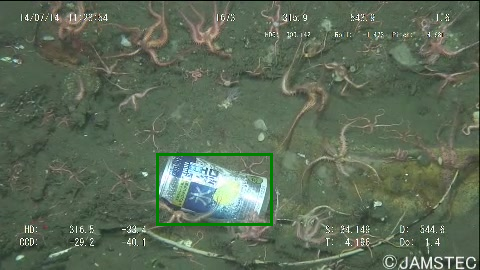

In [22]:
from PIL import Image, ImageDraw

# Load the uploaded image
image_path = '/content/drive/MyDrive/ROV/dataset/instance_version/train/vid_000553_frame0000022.jpg'
image = Image.open(image_path)

# New bounding box for the provided entry in the dataset
xmin3, ymin3, width3, height3 = 156.00378787878788, 153.00251256281408, 116.99071761571764, 72.98135840492785
xmax3 = xmin3 + width3
ymax3 = ymin3 + height3

# Draw the new bounding box on the same image
draw = ImageDraw.Draw(image)
draw.rectangle([(xmin3, ymin3), (xmax3, ymax3)], outline="green", width=3)  # New object (green box)

# Show the updated image with all bounding boxes
image



In [30]:
data[data.file_name == "vid_000553_frame0000022.jpg"].bbox.values[0]

[156.00378787878788, 153.00251256281408, 116.99071761571764, 72.98135840492785]

In [32]:
from PIL import Image, ImageDraw

# Function to draw bounding boxes from a list of boxes
def draw_bounding_boxes(image_path, bboxes, box_colors):
    """
    Draws bounding boxes on the given image.

    Parameters:
    - image_path: Path to the image file.
    - bboxes: List of bounding boxes, each in (xmin, ymin, width, height) format.
    - box_colors: List of colors corresponding to each bounding box.
    """
    # Load the image
    image = Image.open(image_path)

    # Initialize a draw object
    draw = ImageDraw.Draw(image)

    # Assuming bboxes is a list of [xmin, ymin, width, height]
    # Restructure bboxes to be a list of lists
    bboxes = [bboxes]  # Wrap bboxes in an outer list

    # Loop over all bounding boxes
    for i, bbox in enumerate(bboxes):
        # Extract bounding box coordinates from the array
        xmin, ymin, width, height = bbox  # Now bbox is [xmin, ymin, width, height]
        # Calculate xmax, ymax
        xmax = xmin + width
        ymax = ymin + height

        # Draw the rectangle
        draw.rectangle([(xmin, ymin), (xmax, ymax)], outline=box_colors[i], width=3)

    # Show the updated image with bounding boxes
    return image

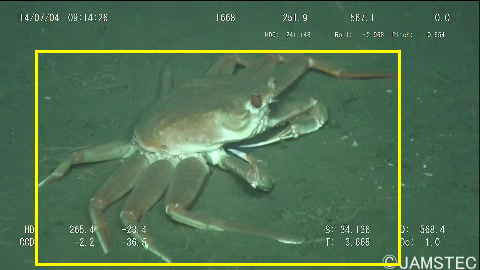

In [35]:
image_path = '/content/drive/MyDrive/ROV/dataset/instance_version/train/vid_000551_frame0000103.jpg'
bboxes = data[data.file_name == "vid_000551_frame0000103.jpg"].bbox.values[0]
box_colors = ["yellow" if x == 1 else "green" for x in data['category_id']]

# Draw the bounding boxes and get the updated image
updated_image = draw_bounding_boxes(image_path, bboxes, box_colors)

# Display the updated image
updated_image


35.01111111111111 50.00617283950617 365.98692810457516 215.9912630579297 400.9980392156863 265.9974358974359


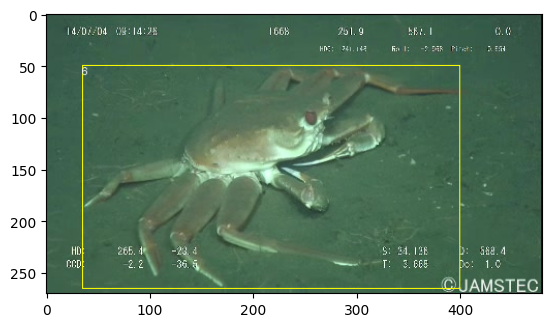

In [36]:
# function to show the ground truth bounding boxes and labels for any image in dataset

def display_groundtruth(filename, data): # data is the dataframe above
    temp = data[data.file_name == filename]
    category_ids = temp.category_id
    box_list = temp.bbox.values

    image = Image.open(r'/content/drive/MyDrive/ROV/dataset/instance_version/train/' + filename)
    #dataset\material_version\val\vid_000002_frame0000013.jpg
    draw = ImageDraw.Draw(image)

    for (xmin, ymin, width, height), label in zip(box_list, category_ids):
        xmax = xmin + width
        ymax = ymin + height

        draw.rectangle([(xmin, ymin), (xmax, ymax)], outline='yellow')
        draw.text((xmin, ymin), text=str(label))

        print(xmin, ymin, width, height, xmax, ymax)

    return image

test_list = ['vid_000551_frame0000103.jpg']

for i,im in enumerate(test_list):
     plt.figure(i)
     plt.imshow(display_groundtruth(im, data))

35.01111111111111 50.00617283950617 365.98692810457516 215.9912630579297 400.9980392156863 265.9974358974359


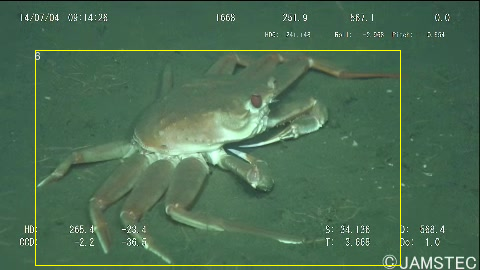

In [37]:
display_groundtruth('vid_000551_frame0000103.jpg', data)


In [38]:
# construct Dataset class for pytorch

class UnderwaterTrashDataset(torch.utils.data.Dataset):
    '''
    Pytorch Dataset class for Underwater Trash Dataset (Trash_CAN 1.0)

    data_file_path := path to pickle file containing dataset (annotations and filenames to images)
    images_path := path to folder containing actual image files
    transforms := from references/detection/transforms.py (pytorch), helps with data transformation and augmentation
    '''

    def __init__(self, data_file_path, images_path, transforms=None):
        if data_file_path:
            self.data = pd.read_pickle(data_file_path)
        self.images_path = images_path
        self.transforms = transforms


    def __getitem__(self, idx):
        temp = data[data.image_id == idx+1]

        image = Image.open(os.path.join(self.images_path, temp.file_name.iloc[0])).convert("RGB")

        box_list = copy.deepcopy(list(temp.bbox))

        for box in box_list: # xmax = xmin + width, ymax = ymin + height
            box[2] = box[2] + box[0]
            box[3] = box[3] + box[1]

        box_list = torch.as_tensor(box_list, dtype=torch.float32)

        labels = torch.as_tensor(temp.category_id.values, dtype=torch.int64)

        image_id = torch.tensor([idx])

        area = (box_list[:, 3] - box_list[:, 1]) * (box_list[:, 2] - box_list[:,0])

        iscrowd = torch.zeros((len(box_list),), dtype=torch.int64)

        target = {}
        target["boxes"] = box_list
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms:
            image, target = self.transforms(image, target)

        return image, target


    def __len__(self):
        return self.data.image_id.nunique()

In [39]:
# parse provided json file which contains annotations for each image

val_dict = {}

with open('/content/drive/MyDrive/ROV/dataset/instance_version/instances_val_trashcan.json') as val:
    val_dict = json.load(val)

In [40]:
val_dict.keys()

dict_keys(['info', 'licenses', 'images', 'annotations', 'categories'])

In [41]:
# compile the relevant data into a pickle file
# (from this point on, just load in pickle file and folder with image files to work with data)

# do images first so can just do a join later:
images = pd.DataFrame(val_dict['images'])
images = images.rename(columns={'id': 'image_id'})

# now do annotations
data = pd.DataFrame(val_dict['annotations'])
data = data.drop(['segmentation', 'iscrowd', 'area'], axis=1)

# merge the two dataframes to give final pickle file
# note, have to use pickle file because bbox contains lists which get read in as strings from csv
data = data.merge(images, on='image_id')
data = data[['image_id', 'id', 'file_name', 'category_id', 'bbox', 'width', 'height']]
# data.to_pickle('UTD_val.pkl', protocol=4)
data.image_id = data.image_id - data.image_id[0]
data

,image_id,id,file_name,category_id,bbox,width,height
0,0,9541,vid_000038_frame0000023.jpg,17,"[331.0078125, 172.03571428571428, 36.982383578...",480,270
1,1,9542,vid_000069_frame0000002.jpg,8,"[357.0020080321285, 148.00980392156862, 37.989...",480,270
2,1,9543,vid_000069_frame0000002.jpg,19,"[98.0040650406504, 50.00471698113208, 287.9903...",480,270
3,2,9544,vid_000090_frame0000048.jpg,22,"[286.0019607843137, 21.001960784313727, 194.99...",480,270
4,2,9545,vid_000090_frame0000048.jpg,22,"[36.001960784313724, 22.001960784313727, 279.9...",480,270
...,...,...,...,...,...,...,...
2583,1145,12124,vid_000085_frame0000041.jpg,8,"[242.00196078431372, 14.001960784313725, 238.9...",480,270
2584,1145,12125,vid_000085_frame0000041.jpg,2,"[188.00196078431372, 47.001960784313724, 107.9...",480,270
2585,1145,12126,vid_000085_frame0000041.jpg,17,"[147.00196078431372, 153.00196078431372, 208.9...",480,270
2586,1146,12127,vid_000298_frame0000022.jpg,17,"[195.00204918032787, 167.02083333333334, 39.98...",480,360


In [42]:
data.category_id.nunique()

22

In [43]:
data.category_id.value_counts()


,category_id
1,684
17,553
12,181
3,153
4,136
16,103
2,102
14,93
7,84
18,68


(array([794., 292.,  32.,  13.,   0.,   5.,   6.,   4.,   0.,   1.]),
 array([ 1. ,  2.8,  4.6,  6.4,  8.2, 10. , 11.8, 13.6, 15.4, 17.2, 19. ]),
 <BarContainer object of 10 artists>)

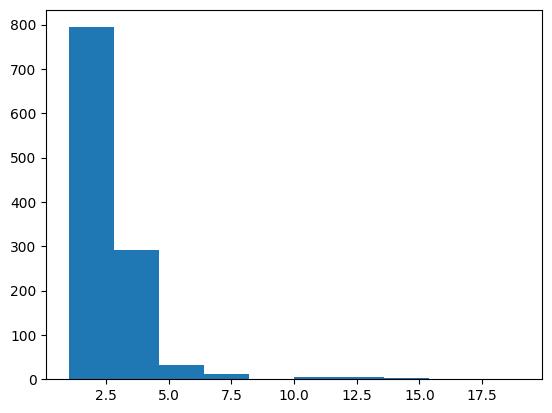

In [44]:
plt.hist(data.image_id.value_counts())

In [45]:
len(data.image_id.value_counts())


1147

In [46]:
t = data.image_id.value_counts()
t[t == 2]

,image_id
1125,2
649,2
646,2
652,2
600,2
...,...
446,2
456,2
444,2
6,2


In [48]:
362/len(data.image_id.value_counts())


0.3156059285091543

In [49]:
data[data['image_id'].map(data['image_id'].value_counts()) == 2].category_id.unique()

array([ 8, 19,  1, 12,  3, 17, 16,  7,  4,  6, 18,  2, 20, 10, 14, 21, 13,
        5, 11, 15,  9])

In [50]:
test = data[data['image_id'].map(data['image_id'].value_counts()) == 2]
test

,image_id,id,file_name,category_id,bbox,width,height
1,1,9542,vid_000069_frame0000002.jpg,8,"[357.0020080321285, 148.00980392156862, 37.989...",480,270
2,1,9543,vid_000069_frame0000002.jpg,19,"[98.0040650406504, 50.00471698113208, 287.9903...",480,270
18,6,9559,vid_000144_frame0000003.jpg,1,"[0.00228310502283105, 177.00574712643677, 122....",480,270
19,6,9560,vid_000144_frame0000003.jpg,12,"[130.00196078431372, 31.001960784313727, 342.9...",480,270
28,10,9569,vid_000152_frame0000027.jpg,1,"[0.00196078431372549, 187.00196078431372, 113....",480,360
...,...,...,...,...,...,...,...
2577,1142,12118,vid_000142_frame0000035.jpg,12,"[62.001960784313724, 70.00196078431372, 284.99...",480,270
2581,1144,12122,vid_000049_frame0000010.jpg,17,"[83.0068493150685, 112.01923076923077, 35.9098...",480,270
2582,1144,12123,vid_000049_frame0000010.jpg,1,"[332.002688172043, 229.07142857142858, 148.972...",480,270
2586,1146,12127,vid_000298_frame0000022.jpg,17,"[195.00204918032787, 167.02083333333334, 39.98...",480,360


In [51]:
data = data[~data.index.isin(test.index)]

In [52]:
data.category_id.nunique()

22

In [53]:
test.category_id.nunique()

21

In [54]:
len(data)


1864

In [55]:
len(test)


724

In [56]:
data.image_id.nunique()


785

In [57]:
test.image_id.nunique()


362

In [58]:
785/6065

0.12943116240725475

In [58]:
(data.category_id - 1).unique()


In [59]:
data

,image_id,id,file_name,category_id,bbox,width,height
0,0,9541,vid_000038_frame0000023.jpg,17,"[331.0078125, 172.03571428571428, 36.982383578...",480,270
3,2,9544,vid_000090_frame0000048.jpg,22,"[286.0019607843137, 21.001960784313727, 194.99...",480,270
4,2,9545,vid_000090_frame0000048.jpg,22,"[36.001960784313724, 22.001960784313727, 279.9...",480,270
5,2,9546,vid_000090_frame0000048.jpg,16,"[43.001960784313724, 159.00196078431372, 58.99...",480,270
6,2,9547,vid_000090_frame0000048.jpg,4,"[1.0019607843137255, 100.00196078431372, 42.99...",480,270
...,...,...,...,...,...,...,...
2579,1143,12120,vid_000077_frame0000042.jpg,8,"[51.001960784313724, 97.00196078431372, 405.99...",480,270
2580,1143,12121,vid_000077_frame0000042.jpg,20,"[96.00196078431372, 0.00196078431372549, 384.9...",480,270
2583,1145,12124,vid_000085_frame0000041.jpg,8,"[242.00196078431372, 14.001960784313725, 238.9...",480,270
2584,1145,12125,vid_000085_frame0000041.jpg,2,"[188.00196078431372, 47.001960784313724, 107.9...",480,270


In [60]:
groups = data.groupby(['file_name'])
x = pd.DataFrame()

count = 0
for name, group in groups:
#     print(name)
    group.image_id = count
#     print(group.image_id)
    x = pd.concat([x, group])
    count += 1

In [61]:
x.image_id.value_counts()

,image_id
122,19
283,15
284,15
118,14
124,14
...,...
246,1
245,1
244,1
243,1


In [62]:
x.file_name.sort_values()


,file_name
184,vid_000002_frame0000013.jpg
427,vid_000002_frame0000014.jpg
103,vid_000002_frame0000015.jpg
1246,vid_000002_frame0000016.jpg
2070,vid_000002_frame0000017.jpg
...,...
1800,vid_000342_frame0000269.jpg
1798,vid_000342_frame0000269.jpg
306,vid_000429_frame0000010.jpg
2513,vid_000429_frame0000013.jpg


In [63]:
x[x.image_id == 457]

,image_id,id,file_name,category_id,bbox,width,height
236,457,9777,vid_000106_frame0000011.jpg,2,"[1.0019607843137255, 185.00196078431372, 477.9...",480,360
237,457,9778,vid_000106_frame0000011.jpg,4,"[186.0040322580645, 253.03125, 30.985098176718...",480,360
238,457,9779,vid_000106_frame0000011.jpg,4,"[222.00819672131146, 247.00446428571428, 33.98...",480,360


In [64]:
data[data.file_name == 'vid_000106_frame0000011.jpg']


,image_id,id,file_name,category_id,bbox,width,height
236,102,9777,vid_000106_frame0000011.jpg,2,"[1.0019607843137255, 185.00196078431372, 477.9...",480,360
237,102,9778,vid_000106_frame0000011.jpg,4,"[186.0040322580645, 253.03125, 30.985098176718...",480,360
238,102,9779,vid_000106_frame0000011.jpg,4,"[222.00819672131146, 247.00446428571428, 33.98...",480,360


In [65]:
data = x.reset_index(drop=True)
data

,image_id,id,file_name,category_id,bbox,width,height
0,0,9725,vid_000002_frame0000013.jpg,9,"[254.00196078431372, 81.00196078431372, 34.996...",480,270
1,1,9968,vid_000002_frame0000014.jpg,9,"[261.0019607843137, 101.00320512820512, 35.996...",480,270
2,2,9644,vid_000002_frame0000015.jpg,9,"[267.0019607843137, 137.00196078431372, 38.996...",480,270
3,3,10787,vid_000002_frame0000016.jpg,9,"[273.0019607843137, 164.00196078431372, 41.996...",480,270
4,4,11611,vid_000002_frame0000017.jpg,9,"[274.0019607843137, 183.00196078431372, 44.996...",480,270
...,...,...,...,...,...,...,...
1859,781,11340,vid_000342_frame0000269.jpg,7,"[197.00196078431372, 232.00196078431372, 35.99...",480,270
1860,781,11341,vid_000342_frame0000269.jpg,7,"[398.0019607843137, 208.00196078431372, 82.996...",480,270
1861,782,9847,vid_000429_frame0000010.jpg,3,"[212.00806451612902, 5.0054945054945055, 149.9...",480,360
1862,783,12054,vid_000429_frame0000013.jpg,3,"[264.0045045045045, 101.00243902439024, 161.98...",480,360


In [66]:
groups = test.groupby(['file_name'])
w = pd.DataFrame()

count = 0
for name, group in groups:
    group.image_id = count
    w = pd.concat([w, group])
    count += 1

test = w.reset_index(drop=True)


test

,image_id,id,file_name,category_id,bbox,width,height
0,0,11469,vid_000004_frame0000010.jpg,17,"[100.00196078431372, 155.5, 27.998039215686276...",480,270
1,0,11470,vid_000004_frame0000010.jpg,17,"[79.00196078431372, 141.00196078431372, 49.996...",480,270
2,1,10992,vid_000004_frame0000011.jpg,20,"[91.0054347826087, 172.00625, 27.9862318840579...",480,270
3,1,10993,vid_000004_frame0000011.jpg,18,"[79.00196078431372, 149.00196078431372, 60.996...",480,270
4,2,11092,vid_000004_frame0000012.jpg,18,"[96.00196078431372, 158.00196078431372, 54.996...",480,270
...,...,...,...,...,...,...,...
719,359,9615,vid_000342_frame0000265.jpg,7,"[240.00196078431372, 163.00196078431372, 26.99...",480,270
720,360,11564,vid_000342_frame0000266.jpg,3,"[161.00196078431372, 136.001968503937, 30.9957...",480,270
721,360,11565,vid_000342_frame0000266.jpg,7,"[226.00196078431372, 178.00196078431372, 35.99...",480,270
722,361,9666,vid_000444_frame0000001.jpg,3,"[278.0019607843137, 129.00196078431372, 24.996...",480,270


In [67]:
w.image_id.value_counts().isin([2]).all() # all the image ids are pairs which is what we expected


True

In [68]:
data.to_pickle('UTD_val.pkl')
test.to_pickle('UTD_test.pkl')

In [69]:
val = pd.read_pickle('UTD_val.pkl')
val

,image_id,id,file_name,category_id,bbox,width,height
0,0,9725,vid_000002_frame0000013.jpg,9,"[254.00196078431372, 81.00196078431372, 34.996...",480,270
1,1,9968,vid_000002_frame0000014.jpg,9,"[261.0019607843137, 101.00320512820512, 35.996...",480,270
2,2,9644,vid_000002_frame0000015.jpg,9,"[267.0019607843137, 137.00196078431372, 38.996...",480,270
3,3,10787,vid_000002_frame0000016.jpg,9,"[273.0019607843137, 164.00196078431372, 41.996...",480,270
4,4,11611,vid_000002_frame0000017.jpg,9,"[274.0019607843137, 183.00196078431372, 44.996...",480,270
...,...,...,...,...,...,...,...
1859,781,11340,vid_000342_frame0000269.jpg,7,"[197.00196078431372, 232.00196078431372, 35.99...",480,270
1860,781,11341,vid_000342_frame0000269.jpg,7,"[398.0019607843137, 208.00196078431372, 82.996...",480,270
1861,782,9847,vid_000429_frame0000010.jpg,3,"[212.00806451612902, 5.0054945054945055, 149.9...",480,360
1862,783,12054,vid_000429_frame0000013.jpg,3,"[264.0045045045045, 101.00243902439024, 161.98...",480,360


In [72]:
def display_groundtruth(filename, data): # data is the dataframe above
    temp = data[data.file_name == filename]
    category_ids = temp.category_id
    box_list = temp.bbox.values

    image = Image.open(r'/content/drive/MyDrive/ROV/dataset/instance_version/val/' + filename)
    #dataset\material_version\val\vid_000002_frame0000013.jpg
    draw = ImageDraw.Draw(image)

    for (xmin, ymin, width, height), label in zip(box_list, category_ids):
        xmax = xmin + width
        ymax = ymin + height

        draw.rectangle([(xmin, ymin), (xmax, ymax)], outline='yellow')
        draw.text((xmin, ymin), text=str(label))

        print(xmin, ymin, width, height, xmax, ymax)

    return image

281.0027173913044 119.00632911392405 169.99428859671957 64.98967088607596 450.99700598802394 183.996


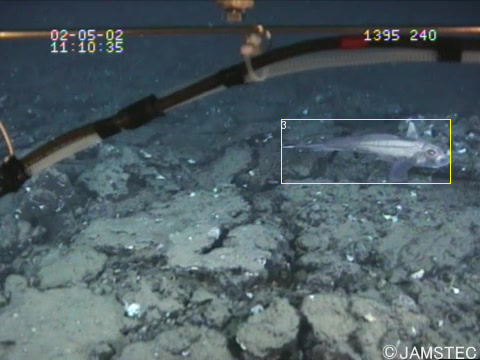

In [75]:
display_groundtruth('vid_000429_frame0000014.jpg', val)

In [76]:
val[val.duplicated(['image_id'])]


,image_id,id,file_name,category_id,bbox,width,height
20,19,11699,vid_000021_frame0000001.jpg,1,"[445.0019607843137, 221.00196078431372, 33.996...",480,270
21,19,11700,vid_000021_frame0000001.jpg,4,"[120.0028409090909, 252.00280898876406, 18.993...",480,270
23,20,9655,vid_000021_frame0000015.jpg,1,"[373.0019607843137, 240.00196078431372, 34.996...",480,270
24,20,9656,vid_000021_frame0000015.jpg,1,"[445.0019607843137, 222.00196078431372, 34.996...",480,270
26,21,9863,vid_000021_frame0000022.jpg,1,"[374.0019607843137, 240.00196078431372, 34.996...",480,270
...,...,...,...,...,...,...,...
1854,779,10357,vid_000342_frame0000267.jpg,7,"[213.00196078431372, 194.00196078431372, 37.99...",480,270
1856,780,9685,vid_000342_frame0000268.jpg,7,"[206.00196078431372, 211.00196078431372, 35.99...",480,270
1857,780,9686,vid_000342_frame0000268.jpg,7,"[413.0019607843137, 192.00196078431372, 66.998...",480,270
1859,781,11340,vid_000342_frame0000269.jpg,7,"[197.00196078431372, 232.00196078431372, 35.99...",480,270


In [77]:
val.category_id.nunique()

22